# Readme

Predictions on the scenarios defined in the article using the 'rnn 9 - data a.' model. The model is retrained beforehand.

# Setup

In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import time
import random
import pickle
import json
import itertools
import importlib
import os

/home/mmip/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append ('functions')

import functions as mf
importlib.reload(mf) 

from rnn_module import AmmoniaRNN

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [4]:
pd.set_option("display.max_columns", None)

# Data processing

## Data embeddings

In [5]:
data_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_rnn_3.csv")

data_embeddings = data_embeddings.drop(['Unnamed: 0'], axis = 1)

In [6]:
data_embeddings['pmid_copy'] = data_embeddings['pmid']

In [7]:
data_embeddings['pmid'] = data_embeddings.apply(
    lambda row: f"{row['pmid']}_{row['dt']}" if row['interpolation'] == "yes" else str(row['pmid']),
    axis=1
)

In [8]:
data_embeddings.shape

(98277, 23)

In [9]:
data_embeddings.head (2)

,e.cum,delta_e.cum,e.cum_shift,dt,dt_origin,inst,pmid,country,meas.tech,ct,air.temp,wind.2m,rain.rate,tan.app,app.mthd,app.rate,man.dm,man.ph,man.source,incorp,t.incorp,interpolation,pmid_copy
0,3.574,3.574,0.000,2.0,4.0,104,182_2.0,DK,micro met,2.0,8.2,8.1,0.0,122.11,0,31.8,3.7,7.35,0,0,1000.0,yes,182
1,7.148,3.574,3.574,2.0,4.0,104,182_2.0,DK,micro met,4.0,8.2,8.1,0.0,122.11,0,31.8,3.7,7.35,0,0,1000.0,yes,182


## Test samples

In [10]:
with open("../00_data_preparation/processed_data/final_train_pmids.json", "r") as f:
    pmids_train = json.load(f)

with open("../00_data_preparation/processed_data/final_eval_pmids.json", "r") as f:
    pmids_eval = json.load(f)

# Training

The model is retrained on a dataset larger than those used during cross-validation.
In the cross-validation procedure, the dataset was split into training, evaluation, and test sets.
Here, the dataset is split into only two parts: training and evaluation.
The evaluation set is used to select the number of epochs.

In [11]:
num_layers = 1
nonlinearity = "relu"
bidirectional = True
mlp = True
with_embeddings = True
response = "delta_e.cum"
hidden_size = 512 

data = data_embeddings
cat_dims = [5, 3, 2]  
embedding_dims = [10, 9, 8]  
input_size = 13   
output_size = 1

torch.manual_seed(1)
model = AmmoniaRNN(input_size = input_size, 
                   output_size = output_size, 
                   hidden_size = hidden_size, 
                   nonlinearity = nonlinearity,
                   num_layers = num_layers,
                   bidirectional = bidirectional,
                   mlp = mlp,
                   with_embeddings = with_embeddings, 
                   cat_dims = cat_dims, 
                   embedding_dims = embedding_dims).to(DEVICE)

filename_model = f'results/06_predictions_on_scenarios/final_model'

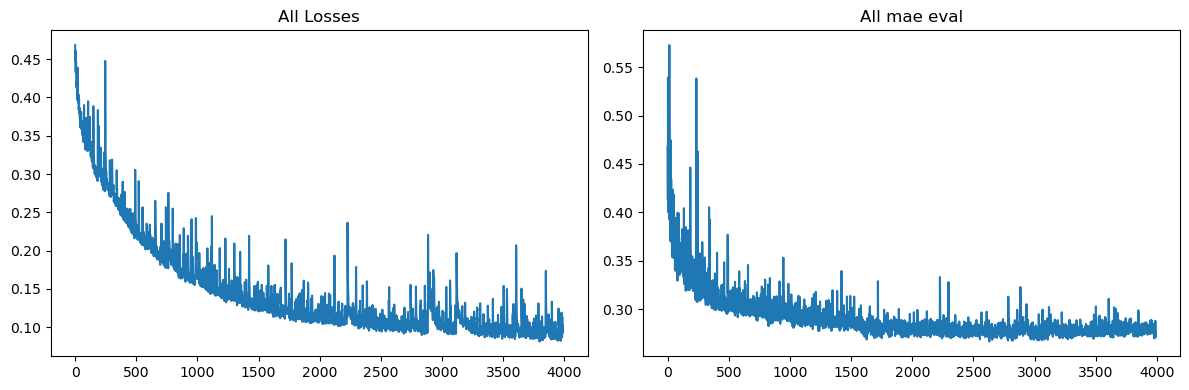

In [12]:
with open(f'results/06_predictions_on_scenarios/all_mae_eval.pkl', "rb") as f:
    all_mae_eval = pickle.load(f)

with open(f'results/06_predictions_on_scenarios/all_losses.pkl', "rb") as f:
    all_losses = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes[0].plot(all_losses[10:])
axes[0].set_title('All Losses')

axes[1].plot(all_mae_eval[10:])
axes[1].set_title('All mae eval')

plt.tight_layout()
plt.show()

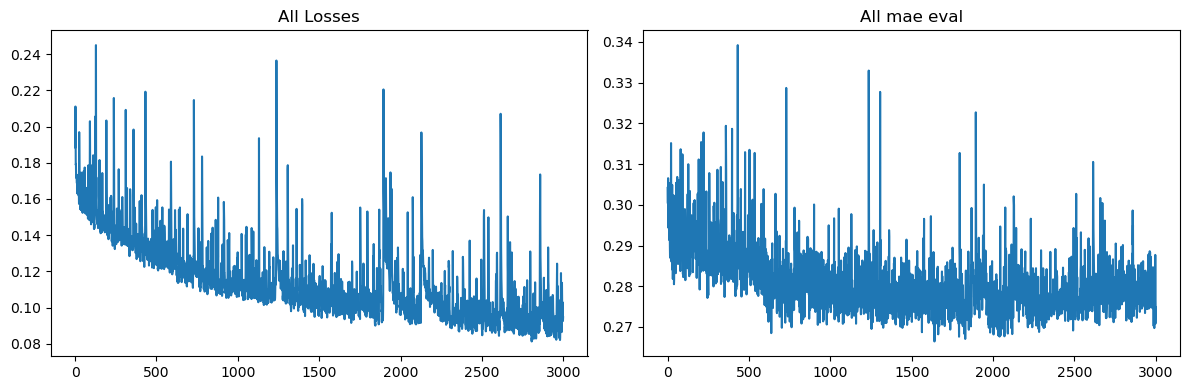

In [13]:
with open(f'results/06_predictions_on_scenarios/all_mae_eval.pkl', "rb") as f:
    all_mae_eval = pickle.load(f)

with open(f'results/06_predictions_on_scenarios/all_losses.pkl', "rb") as f:
    all_losses = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes[0].plot(all_losses[1000:])
axes[0].set_title('All Losses')

axes[1].plot(all_mae_eval[1000:])
axes[1].set_title('All mae eval')

plt.tight_layout()
plt.show()

# Predictions on scenarios

In [14]:
data_scenarios = pd.read_csv("../00_data_preparation/processed_data/scenarios_rnn.csv")

In [15]:
data_scenarios = data_scenarios.drop(['Unnamed: 0'], axis = 1)

In [16]:
data_scenarios.head (2)

,scenario,pmid,strategy,group_temp,group_wind,group_rain,ct,dt,air.temp,wind.2m,rain.rate,tan.app,app.mthd,app.rate,man.dm,man.ph,man.source,incorp,t.incorp,seq,ct_shift
0,1,1,Incorporation,1,1,1,2,2,11.2,2.3,0.0,36.7,0,18.7,3.8,7.5,0,1,0,2,0
1,1,1,Incorporation,1,1,1,4,2,11.2,2.3,0.0,36.7,0,18.7,3.8,7.5,0,1,0,2,2


In [17]:
data_scenarios[(data_scenarios['pmid'] == 4001) & (data_scenarios['seq'].isin ([8, 10]))]

,scenario,pmid,strategy,group_temp,group_wind,group_rain,ct,dt,air.temp,wind.2m,rain.rate,tan.app,app.mthd,app.rate,man.dm,man.ph,man.source,incorp,t.incorp,seq,ct_shift
57600,1,4001,Incorporation,1,1,1,2,2,11.20,2.30,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,0
57601,1,4001,Incorporation,1,1,1,12,10,10.04,2.10,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,2
57602,1,4001,Incorporation,1,1,1,22,10,8.28,1.56,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,12
57603,1,4001,Incorporation,1,1,1,32,10,9.20,2.20,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,22
57604,1,4001,Incorporation,1,1,1,42,10,9.20,2.20,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,32
57605,1,4001,Incorporation,1,1,1,52,10,9.20,2.20,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,42
57606,1,4001,Incorporation,1,1,1,62,10,9.20,2.20,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,52
57607,1,4001,Incorporation,1,1,1,72,10,9.20,2.20,0.0,36.7,0,18.7,3.8,7.5,0,1,0,10,62


In [18]:
pmids_scenarios = data_scenarios['pmid'].unique()

In [19]:
seq = data_scenarios['seq'].unique()

In [20]:
data_scenarios['prediction_ecum'] = None
data_scenarios['prediction_delta_ecum'] = None
    
with torch.no_grad():

    all_predictions = torch.empty(0).to(DEVICE)

    model.load_state_dict(torch.load(filename_model + '.pth', weights_only = True, map_location=torch.device('cpu')))
        
    for i in pmids_scenarios:

        x = mf.generate_tensors_predictors (data_scenarios, i, with_embeddings, device = DEVICE)
        y = model(x)
        all_predictions = torch.cat ((all_predictions, y.squeeze()), 0)

    data_scenarios['prediction_delta_ecum'] = all_predictions.to("cpu").detach()

data_scenarios['prediction_ecum'] = data_scenarios.groupby('pmid')['prediction_delta_ecum'].cumsum()

In [21]:
data_scenarios.to_csv('results/06_predictions_on_scenarios/predictions_on_scenarios_rnn_data_augmentation.csv', index = False)  

In [22]:
data_scenarios.head (2)

,scenario,pmid,strategy,group_temp,group_wind,group_rain,ct,dt,air.temp,wind.2m,rain.rate,tan.app,app.mthd,app.rate,man.dm,man.ph,man.source,incorp,t.incorp,seq,ct_shift,prediction_ecum,prediction_delta_ecum
0,1,1,Incorporation,1,1,1,2,2,11.2,2.3,0.0,36.7,0,18.7,3.8,7.5,0,1,0,2,0,1.628788,1.628788
1,1,1,Incorporation,1,1,1,4,2,11.2,2.3,0.0,36.7,0,18.7,3.8,7.5,0,1,0,2,2,1.662179,0.033392


# End